In [1]:
import numpy as np
import matplotlib.pyplot as plt
import swyft
import torch
from scipy import interpolate

In [2]:
from swyft.intensity import FactorMask, Intensity, Mask1d, get_factor_mask_from_intervals

# LOAD FILES

### LOAD MEASUREMENTS

In [3]:
redz = ['1.0']
mbin = ['1','2','3']
sim = ['gaussian']

filesh = np.zeros((len(redz),len(mbin),len(sim)),dtype='<U255')

for i in range(len(redz)):
    for j in range(len(mbin)):
        for k in range(len(sim)):
                filesh[i,j,k] = 'NbodyMeasurements/avgps_hh_z%s_B%s_byagox_%s_1536_2Gpc_085.dat' %(redz[i],mbin[j],sim[k])


num_lines=0
with open(filesh[0,0,0], 'r') as f:
    for line in f:
        num_lines += 1
num_lines -= 2

phh = np.zeros((len(redz),len(mbin),len(sim),num_lines))
sphh = np.zeros((len(redz),len(mbin),len(sim),num_lines))
shot = np.zeros((len(redz),len(mbin),len(sim)))
        
kvec, avgk = np.loadtxt(filesh[0,0,0],float,usecols=(0,1),unpack=True)
        
for i in range(len(redz)):
    for j in range(len(mbin)):
        for k in range(len(sim)):              
                data = np.loadtxt(filesh[i,j,k],float,skiprows=2)
                shot[i,j,k]=data[0,4]
                phh[i,j,k,:] = data[0:num_lines,2]+shot[i,j,k]
                sphh[i,j,k,:] = data[0:num_lines,3]

### LOAD THEORY

In [4]:
kth, p1loop,pctr,id2d2,id2,ig2,id2g2,ig2g2,ifg2,ptree = np.loadtxt('TheoryPredictions/EOS_gaussian_pk_nl_pt.dat', unpack = True,skiprows=4)
dgrow0=0.777937
dgrow1=0.476789
facz1=(dgrow1/dgrow0)**2
p1loopint=interpolate.splrep(kth,p1loop/(2*np.pi)**3*facz1)
pctrint=interpolate.splrep(kth,pctr/(2*np.pi)**3*facz1)
pid2d2int=interpolate.splrep(kth,id2d2/(2*np.pi)**3*facz1)
pid2int=interpolate.splrep(kth,id2/(2*np.pi)**3*facz1)
pig2int=interpolate.splrep(kth,ig2/(2*np.pi)**3*facz1)
pid2g2int=interpolate.splrep(kth,id2g2/(2*np.pi)**3*facz1)
pig2g2int=interpolate.splrep(kth,ig2g2/(2*np.pi)**3*facz1)
pifg2int=interpolate.splrep(kth,ifg2/(2*np.pi)**3*facz1)
ptreeint=interpolate.splrep(kth,ptree/(2*np.pi)**3*facz1)

# Prepare Theoretical prediction

In [5]:
def pgal(k,mbin,b1,b2,bg2,bg3,cs,ek2,alpha):
    val = b1**2*(ptreeint(k)+p1loopint(k))+ b1*b2*pid2int(k)
    val += 2*b1*bg2*pig2int(k)+b1*(2*bg2+4/5*bg3)*pifg2int(k)
    val += 1/4*b2**2*pid2d2int(k)+bg2**2*pig2g2int(k)+b2*bg2*pid2g2int(k)
    val += cs**2*pctrint(k) + (1+alpha)*shot[0,mbin-1,0] + ek2*shot[0,mbin-1,0]*k**2
    return val

## Try simple least squares minimization

In [6]:
kmax=0.4
ksim = avgk[avgk<kmax]
powsim = phh[0,0,0,avgk<kmax]
sigmapow = sphh[0,0,0,avgk<kmax]

p1loopintev=interpolate.splev(ksim,p1loopint)
pctrintev=interpolate.splev(ksim,pctrint)
pid2d2intev=interpolate.splev(ksim,pid2d2int)
pid2intev=interpolate.splev(ksim,pid2int)
pig2intev=interpolate.splev(ksim,pig2int)
pid2g2intev=interpolate.splev(ksim,pid2g2int)
pig2g2intev=interpolate.splev(ksim,pig2g2int)
pifg2intev=interpolate.splev(ksim,pifg2int)
ptreeintev=interpolate.splev(ksim,ptreeint)

For now, hack the prior into unit hypercube

In [7]:
def simulator(z):
    #b1,b2,bg2,bg3,cs,alpha,ek2 = 20*(z[0]-0.5),20*(z[1]-0.5),20*(z[2]-0.5),20*(z[3]-0.5),200*(z[4]-0.5),\
    #    2*(z[5]-0.5),20*(z[6]-0.5)
    b1,b2,bg2,bg3,cs,alpha,ek2 = z[0],z[1],z[2],z[3],z[4],z[5],z[6]
    x=b1**2*(ptreeintev+p1loopintev)+ b1*b2*pid2intev+\
            2*b1*bg2*pig2intev+b1*(2*bg2+4/5*bg3)*pifg2intev+\
            1/4*b2**2*pid2d2intev+bg2**2*pig2g2intev+b2*bg2*pid2g2intev+\
            cs**2*pctrintev + (1+alpha)*shot[0,0,0] + ek2*shot[0,0,0]*ksim**2
    return x

def noise(x,z=None):
    n = np.random.randn(*x.shape)*sigmapow
    return x + n

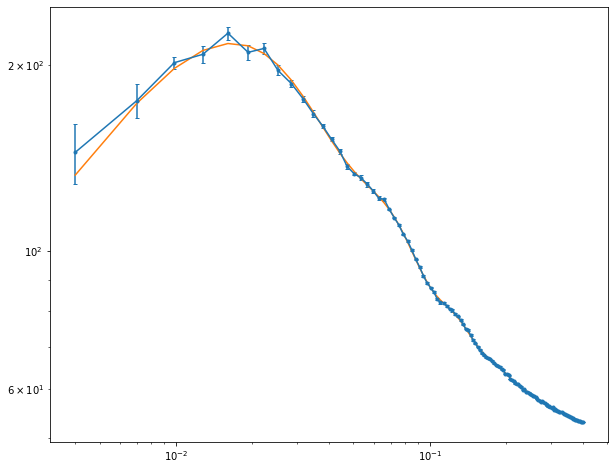

In [8]:
plt.figure(figsize=[10,8]);
plt.errorbar(ksim,powsim, yerr=sigmapow, marker='o', ms=3, capsize=2, label='sim' );
plt.plot(ksim,simulator([2.08471636,0.60472895,1.23511048,-3.74206224,-7.8578e-06,-0.07530319,0.12946018]));
plt.xscale('log');
plt.yscale('log');

In [8]:
x0=powsim
zdim=7

In [9]:
DEVICE = 'cuda:0'
MAX_EPOCHS = 100
EXPECTED_N = 10000

hack for get custom flat prior

In [10]:
iFM=FactorMask([Mask1d([elm]) for elm in [[0.01,10.0],[-10.0,10.0],[-10.0,10.0],[-10.0,10.0],\
                                     [-100.0,100.0],[-1.0,1.0],[-10.0,10.0]]])

In [11]:
cache = swyft.MemoryCache(zdim = zdim, xshape = x0.shape)

Creating new cache.


In [12]:
class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv1d(1, 10, 3)
        self.conv2 = torch.nn.Conv1d(10, 20, 3)
        self.conv3 = torch.nn.Conv1d(20, 40, 3)
        self.pool = torch.nn.MaxPool1d(2)
        
    def forward(self, x):
        nbatch = len(x)
        
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

In [13]:
res=[]

In [14]:
intensity = None
pre = None
for i in range(4):
    if intensity is None:
        #intensity = swyft.get_unit_intensity(
        #    expected_n=EXPECTED_N, 
        #    dim=zdim
        #)
        intensity=Intensity(EXPECTED_N,iFM)
    else:
        intensity = swyft.get_constrained_intensity(
            expected_n=EXPECTED_N,
            ratio_estimator=re,
            x0=x0,
            threshold=1e-4,
        )
    
    cache.grow(intensity)
    cache.simulate(simulator)
    
    points = swyft.Points(cache, intensity, noise)
    
    statistics = swyft.get_statistics(points)
    re = swyft.RatioEstimator(
        points, 
        device=DEVICE, 
        statistics=statistics, head=Head(), previous_ratio_estimator=pre
    )
    res.append(re)
    res[-1].train(
        max_epochs=MAX_EPOCHS, 
        batch_size=32, 
        lr_schedule=[1e-3, 3e-4, 1e-4],
        early_stopping_patience=2
    )
    pre = res[-1]

Simulate:   2%|▏         | 199/9992 [00:00<00:04, 1985.32it/s]

Adding 9992 new samples. Run simulator!


Simulate: 100%|██████████| 9992/9992 [00:04<00:00, 2353.27it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 560
Start training
LR iteration 0
Validation loss: 519.2107381820679
Validation loss: 489.1475992202759
Validation loss: 501.8441972732544
Validation loss: 482.3250741958618
Validation loss: 464.56776905059814
Validation loss: 445.28772926330566
Validation loss: 443.1062650680542
Validation loss: 447.04068183898926
Validation loss: 429.66534900665283
Validation loss: 428.432580947876
Validation loss: 410.22410678863525
Validation loss: 395.89881706237793
Validation loss: 381.07817554473877
Validation loss: 380.0278778076172
Validation loss: 375.1158447265625
Validation loss: 369.98172092437744
Validation loss: 369.08246898651123
Validation loss: 354.9782133102417
Validation loss: 392.21527099609375
Validation loss: 352.93532848358154
Validation loss: 348.30832958221436
Validation loss: 357.2375202178955
Validation loss: 342.49586296081543
Validation loss: 346.15558338165283
Validation loss: 336.7237081527

Simulate:   2%|▏         | 237/9969 [00:00<00:04, 2366.01it/s]

Constrained posterior area: 2618481.473466009
Adding 9969 new samples. Run simulator!


Simulate: 100%|██████████| 9969/9969 [00:04<00:00, 2336.08it/s]


No new simulator runs required.


/var/scratch/aecole/miniconda3/lib/python3.8/site-packages/swyft/estimation.py:91: UserWarning: using previous ratio estimator's head rather than yours.
  warn("using previous ratio estimator's head rather than yours.")


yshape (shape of features between head and legs): 560
Start training
LR iteration 0
Validation loss: 460.1145362854004
Validation loss: 420.3886299133301
Validation loss: 407.1377649307251
Validation loss: 388.97047901153564
Validation loss: 373.4243965148926
Validation loss: 360.4112014770508
Validation loss: 364.16367053985596
Validation loss: 353.0445976257324
Validation loss: 336.4814682006836
Validation loss: 332.8424072265625
Validation loss: 336.6310558319092
Validation loss: 348.76792430877686
Total epochs: 12
LR iteration 1
Validation loss: 310.67687129974365
Validation loss: 312.28380489349365
Validation loss: 318.49493503570557
Total epochs: 3
LR iteration 2
Validation loss: 305.97624015808105
Validation loss: 298.72037076950073
Validation loss: 305.2690238952637
Validation loss: 302.741418838501
Total epochs: 4


Simulate:   2%|▏         | 237/9622 [00:00<00:03, 2367.48it/s]

Constrained posterior area: 91372.22622952712
Adding 9622 new samples. Run simulator!


Simulate: 100%|██████████| 9622/9622 [00:04<00:00, 2357.74it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 560
Start training
LR iteration 0
Validation loss: 467.41314792633057
Validation loss: 460.8820571899414
Validation loss: 433.72782135009766
Validation loss: 425.08111476898193
Validation loss: 414.26798725128174
Validation loss: 411.7285108566284
Validation loss: 396.587646484375
Validation loss: 402.1258592605591
Validation loss: 394.3077793121338
Validation loss: 387.21985816955566
Validation loss: 393.7165298461914
Validation loss: 386.3228979110718
Validation loss: 396.9112901687622
Validation loss: 390.4402484893799
Total epochs: 14
LR iteration 1
Validation loss: 373.13817596435547
Validation loss: 370.30894565582275
Validation loss: 364.3578176498413
Validation loss: 365.38957691192627
Validation loss: 372.07141399383545
Total epochs: 5
LR iteration 2
Validation loss: 348.21750926971436
Validation loss: 349.63434314727783
Validation loss: 346.7325086593628
Validation loss: 349.49811363220215
Valid

Simulate:   3%|▎         | 237/8757 [00:00<00:03, 2366.40it/s]

Constrained posterior area: 11840.551291892405
Adding 8757 new samples. Run simulator!


Simulate: 100%|██████████| 8757/8757 [00:03<00:00, 2359.34it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 560
Start training
LR iteration 0
Validation loss: 474.88119983673096
Validation loss: 454.2194585800171
Validation loss: 445.65228366851807
Validation loss: 444.2246837615967
Validation loss: 436.5039825439453
Validation loss: 421.4674253463745
Validation loss: 415.91936111450195
Validation loss: 417.94904136657715
Validation loss: 411.1336784362793
Validation loss: 399.7994737625122
Validation loss: 404.49386978149414
Validation loss: 399.9839839935303
Total epochs: 12
LR iteration 1
Validation loss: 379.4548454284668
Validation loss: 376.7798099517822
Validation loss: 373.841814994812
Validation loss: 380.62649631500244
Validation loss: 374.5153999328613
Total epochs: 5
LR iteration 2
Validation loss: 370.1825246810913
Validation loss: 363.2798738479614
Validation loss: 368.46848583221436
Validation loss: 362.9509344100952
Validation loss: 364.5308790206909
Validation loss: 363.6642017364502
Total epoc

In [15]:
labels=['$b_1$','$b_2$','$b_{G_2}$','$b_{\\Gamma_3}$','$b_{\\tilde{\\nabla}^2}$', '$\\alpha_1$','$\\alpha_2$']

In [16]:
params=[5,6,4,0,1,2,3]

In [17]:
labelsordered=np.array(labels)[params]

In [18]:
def plot1d(
    re1d,
    x0=None,
    dims = (15, 5),
    ncol= None,
    params=None,
    labels = None,
    z0= None,
    cmap= "Greys",
    max_n_points = 1000,
    fontsize=18
):
    # TODO: Rewrite
    if params is None:
        params = range(re1d.zdim)

    if ncol is None:
        ncol = re1d.zdim

    K = len(params)
    nrow = (K - 1) // ncol + 1

    fig, axes = plt.subplots(nrow, ncol, figsize=dims)
    lb = 0.125
    tr = 0.9
    whspace = 0.15
    fig.subplots_adjust(
        left=lb, bottom=lb, right=tr, top=tr, wspace=whspace, hspace=whspace
    )

    if labels is None:
        labels = ["z%i" % params[i] for i in range(K)]
    for k in range(K):
        if nrow == 1:
            ax = axes[k]
        else:
            i, j = k % ncol, k // ncol
            ax = axes[j, i]
        swyft.plot.hist1d(ax, re1d, x0, z0, params[k], max_n_points=max_n_points)
        ax.set_xlabel(labels[k], fontsize=fontsize)

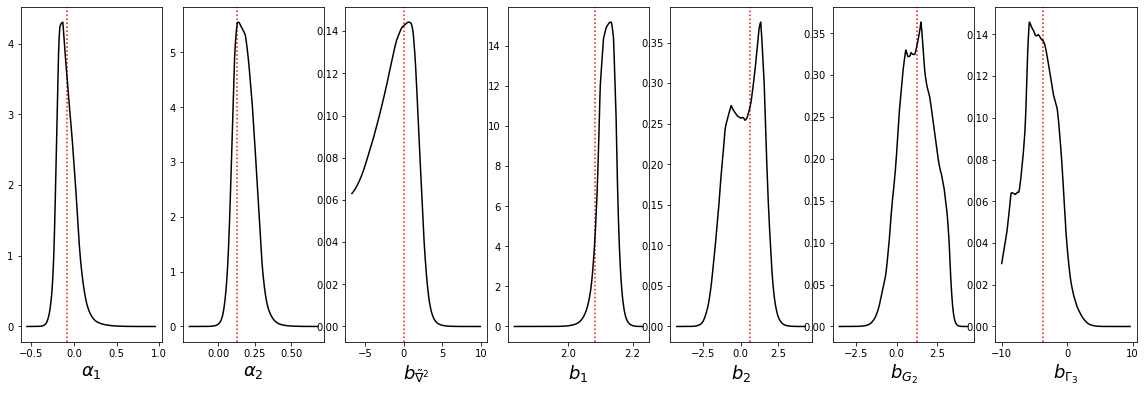

In [22]:
plot1d(res[-1], x0 = x0,
       z0 = np.array([2.08471636,0.60472895,1.23511048,-3.74206224,-7.8578e-06,-0.07530319,0.12946018]),
       params=params, labels=labelsordered,
             cmap = 'Greys', dims = (20,6),max_n_points=10000);

In [23]:
cache.__len__()

38340

In [24]:
for i in range(4):
    if intensity is None:
        #intensity = swyft.get_unit_intensity(
        #    expected_n=EXPECTED_N, 
        #    dim=zdim
        #)
        intensity=Intensity(EXPECTED_N,iFM)
    else:
        intensity = swyft.get_constrained_intensity(
            expected_n=EXPECTED_N,
            ratio_estimator=re,
            x0=x0,
            threshold=1e-4,
        )
    
    cache.grow(intensity)
    cache.simulate(simulator)
    
    points = swyft.Points(cache, intensity, noise)
    
    statistics = swyft.get_statistics(points)
    re = swyft.RatioEstimator(
        points, 
        device=DEVICE, 
        statistics=statistics, head=Head(), previous_ratio_estimator=pre
    )
    res.append(re)
    res[-1].train(
        max_epochs=MAX_EPOCHS, 
        batch_size=32, 
        lr_schedule=[1e-3, 3e-4, 1e-4],
        early_stopping_patience=2
    )
    pre = res[-1]

Simulate:   3%|▎         | 236/7770 [00:00<00:03, 2355.00it/s]

Constrained posterior area: 2580.12943139601
Adding 7770 new samples. Run simulator!


Simulate: 100%|██████████| 7770/7770 [00:03<00:00, 2379.65it/s]


No new simulator runs required.


/var/scratch/aecole/miniconda3/lib/python3.8/site-packages/swyft/estimation.py:91: UserWarning: using previous ratio estimator's head rather than yours.
  warn("using previous ratio estimator's head rather than yours.")


yshape (shape of features between head and legs): 560
Start training
LR iteration 0
Validation loss: 475.3072862625122
Validation loss: 457.89156913757324
Validation loss: 440.05688762664795
Validation loss: 429.283896446228
Validation loss: 431.9924192428589
Validation loss: 430.46234703063965
Total epochs: 6
LR iteration 1
Validation loss: 415.8934087753296
Validation loss: 409.9537572860718
Validation loss: 401.36571311950684
Validation loss: 396.96196937561035
Validation loss: 397.6740369796753
Validation loss: 397.87431716918945
Total epochs: 6
LR iteration 2
Validation loss: 389.24324893951416
Validation loss: 384.19849491119385
Validation loss: 386.6796808242798
Validation loss: 386.6197319030762
Total epochs: 4


Simulate:   0%|          | 0/3785 [00:00<?, ?it/s]

Constrained posterior area: 1588.324015622681
Adding 3785 new samples. Run simulator!


Simulate: 100%|██████████| 3785/3785 [00:01<00:00, 2354.58it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 560
Start training
LR iteration 0
Validation loss: 480.9975872039795
Validation loss: 464.33182525634766
Validation loss: 447.8233118057251
Validation loss: 449.22235107421875
Validation loss: 445.168625831604
Validation loss: 434.7641534805298
Validation loss: 429.06821727752686
Validation loss: 427.4870615005493
Validation loss: 419.0921220779419
Validation loss: 419.1945514678955
Validation loss: 413.62781715393066
Validation loss: 419.6216583251953
Validation loss: 401.8023281097412
Validation loss: 418.64462089538574
Validation loss: 402.19375801086426
Total epochs: 15
LR iteration 1
Validation loss: 392.0808057785034
Validation loss: 384.00182819366455
Validation loss: 386.85998153686523
Validation loss: 381.32294750213623
Validation loss: 388.2599067687988
Validation loss: 385.1677255630493
Total epochs: 6
LR iteration 2
Validation loss: 380.05443000793457
Validation loss: 379.78525161743164
Valida

Simulate:   0%|          | 0/5448 [00:00<?, ?it/s]

Constrained posterior area: 727.5265117651178
Adding 5448 new samples. Run simulator!


Simulate: 100%|██████████| 5448/5448 [00:02<00:00, 2322.45it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 560
Start training
LR iteration 0
Validation loss: 490.0947370529175
Validation loss: 475.1817750930786
Validation loss: 473.9982376098633
Validation loss: 468.73218059539795
Validation loss: 458.4902038574219
Validation loss: 452.72345066070557
Validation loss: 450.8211727142334
Validation loss: 436.8214912414551
Validation loss: 434.12192153930664
Validation loss: 456.0761079788208
Validation loss: 427.90067768096924
Validation loss: 438.01364612579346
Validation loss: 428.19156551361084
Total epochs: 13
LR iteration 1
Validation loss: 408.4532766342163
Validation loss: 412.2937135696411
Validation loss: 410.77380084991455
Total epochs: 3
LR iteration 2
Validation loss: 406.81531524658203
Validation loss: 404.9346742630005
Validation loss: 404.31053352355957
Validation loss: 398.42348289489746
Validation loss: 401.60288429260254
Validation loss: 406.0607919692993
Total epochs: 6


Simulate:   0%|          | 0/2455 [00:00<?, ?it/s]

Constrained posterior area: 554.8419328460039
Adding 2455 new samples. Run simulator!


Simulate: 100%|██████████| 2455/2455 [00:01<00:00, 2388.79it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 560
Start training
LR iteration 0
Validation loss: 518.6118431091309
Validation loss: 493.13819885253906
Validation loss: 480.66712760925293
Validation loss: 463.87502098083496
Validation loss: 461.29209423065186
Validation loss: 458.2749147415161
Validation loss: 442.22404193878174
Validation loss: 465.2398290634155
Validation loss: 441.0849847793579
Validation loss: 439.4681158065796
Validation loss: 438.6157035827637
Validation loss: 430.20978450775146
Validation loss: 430.665771484375
Validation loss: 431.44426918029785
Total epochs: 14
LR iteration 1
Validation loss: 431.58094120025635
Validation loss: 427.0958423614502
Validation loss: 430.8409595489502
Validation loss: 425.98960304260254
Validation loss: 422.7307291030884
Validation loss: 418.85934257507324
Validation loss: 412.8377380371094
Validation loss: 416.6040802001953
Validation loss: 426.1213903427124
Total epochs: 9
LR iteration 2
Validat

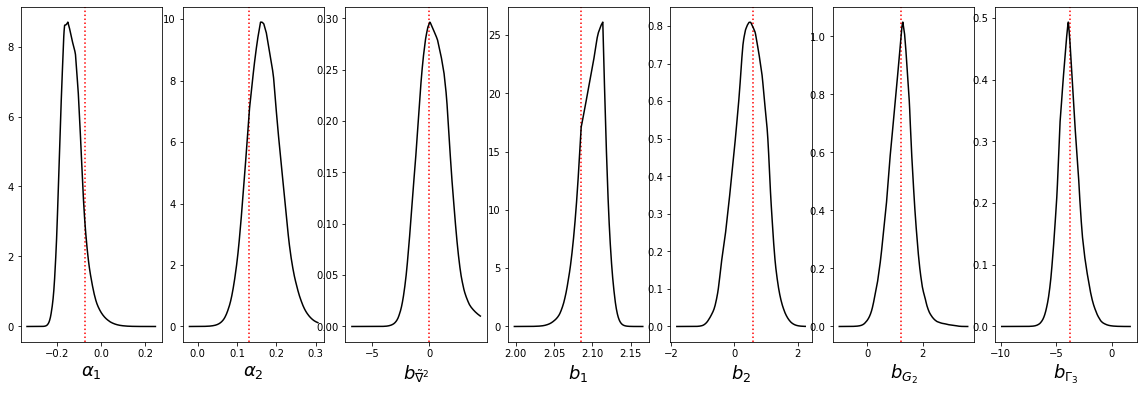

In [28]:
plot1d(res[-1], x0 = x0,
       z0 = np.array([2.08471636,0.60472895,1.23511048,-3.74206224,-7.8578e-06,-0.07530319,0.12946018]),
       params=params, labels=labelsordered,
             cmap = 'Greys', dims = (20,6),max_n_points=10000);

In [26]:
for i in range(2):
    if intensity is None:
        #intensity = swyft.get_unit_intensity(
        #    expected_n=EXPECTED_N, 
        #    dim=zdim
        #)
        intensity=Intensity(EXPECTED_N,iFM)
    else:
        intensity = swyft.get_constrained_intensity(
            expected_n=40000,
            ratio_estimator=re,
            x0=x0,
            threshold=1e-4,
        )
    
    cache.grow(intensity)
    cache.simulate(simulator)
    
    points = swyft.Points(cache, intensity, noise)
    
    statistics = swyft.get_statistics(points)
    re = swyft.RatioEstimator(
        points, 
        device=DEVICE, 
        statistics=statistics, head=Head(), previous_ratio_estimator=pre
    )
    res.append(re)
    res[-1].train(
        max_epochs=MAX_EPOCHS, 
        batch_size=32, 
        lr_schedule=[1e-3, 3e-4, 1e-4],
        early_stopping_patience=2
    )
    pre = res[-1]

Constrained posterior area: 397.1795460046719


Simulate:   1%|          | 237/33144 [00:00<00:13, 2362.72it/s]

Adding 33144 new samples. Run simulator!


Simulate: 100%|██████████| 33144/33144 [00:14<00:00, 2339.01it/s]


No new simulator runs required.


/var/scratch/aecole/miniconda3/lib/python3.8/site-packages/swyft/estimation.py:91: UserWarning: using previous ratio estimator's head rather than yours.
  warn("using previous ratio estimator's head rather than yours.")


yshape (shape of features between head and legs): 560
Start training
LR iteration 0
Validation loss: 1849.3315649032593
Validation loss: 1761.7273054122925
Validation loss: 1719.1286211013794
Validation loss: 1711.5674133300781
Validation loss: 1685.8709201812744
Validation loss: 1686.7061319351196
Validation loss: 1683.5963592529297
Validation loss: 1658.3399353027344
Validation loss: 1653.0767974853516
Validation loss: 1643.3659782409668
Validation loss: 1666.492070198059
Validation loss: 1616.3064107894897
Validation loss: 1631.122657775879
Validation loss: 1602.0486860275269
Validation loss: 1624.6956014633179
Validation loss: 1653.842204093933
Total epochs: 16
LR iteration 1
Validation loss: 1554.4975280761719
Validation loss: 1569.7271871566772
Validation loss: 1543.4404134750366
Validation loss: 1561.3026523590088
Validation loss: 1548.557933807373
Total epochs: 5
LR iteration 2
Validation loss: 1532.7637586593628
Validation loss: 1529.37726688385
Validation loss: 1530.617381095

Simulate:   1%|          | 236/32146 [00:00<00:13, 2351.25it/s]

Adding 32146 new samples. Run simulator!


Simulate: 100%|██████████| 32146/32146 [00:13<00:00, 2340.53it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 560
Start training
LR iteration 0
Validation loss: 1938.7286081314087
Validation loss: 1852.4225215911865
Validation loss: 1809.373052597046
Validation loss: 1775.6027507781982
Validation loss: 1744.9536609649658
Validation loss: 1766.763095855713
Validation loss: 1742.4209823608398
Validation loss: 1742.1822385787964
Validation loss: 1730.0276832580566
Validation loss: 1783.9596710205078
Validation loss: 1703.6611166000366
Validation loss: 1716.704574584961
Validation loss: 1743.7776069641113
Total epochs: 13
LR iteration 1
Validation loss: 1661.3347282409668
Validation loss: 1651.4466247558594
Validation loss: 1657.60533618927
Validation loss: 1654.0819187164307
Total epochs: 4
LR iteration 2
Validation loss: 1634.2157850265503
Validation loss: 1629.1642570495605
Validation loss: 1632.4410037994385
Validation loss: 1632.1781120300293
Total epochs: 4


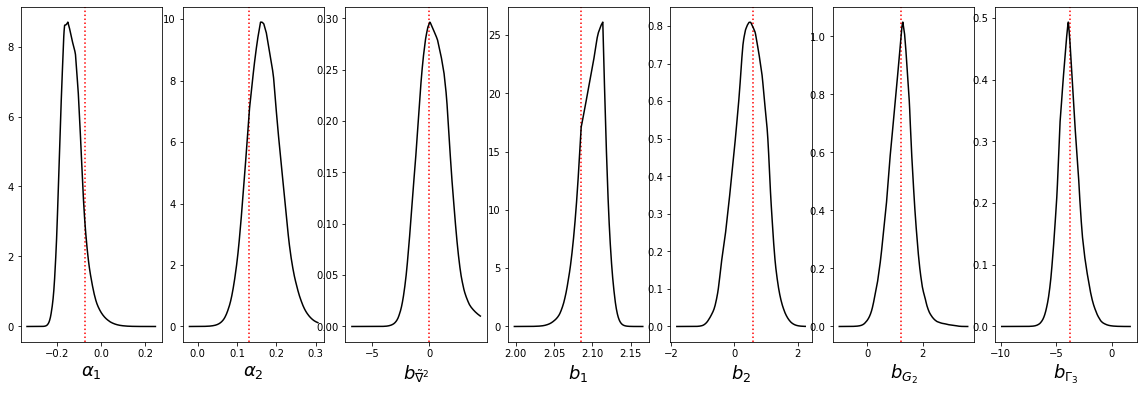

In [27]:
plot1d(res[-1], x0 = x0,
       z0 = np.array([2.08471636,0.60472895,1.23511048,-3.74206224,-7.8578e-06,-0.07530319,0.12946018]),
       params=params, labels=labelsordered,
             cmap = 'Greys', dims = (20,6),max_n_points=10000);

In [29]:
cache.__len__()

123088

In [30]:
from swyft.utils import get_stats

In [31]:
medlist=[]
for i in range(res[-1].zdim):
    z, p = re.posterior(x0, i)
    medlist.append(get_stats(z, p)['median'])
    #print("z%i = %.5f +- %.5f" % (i, res["median"], res["err68"]))

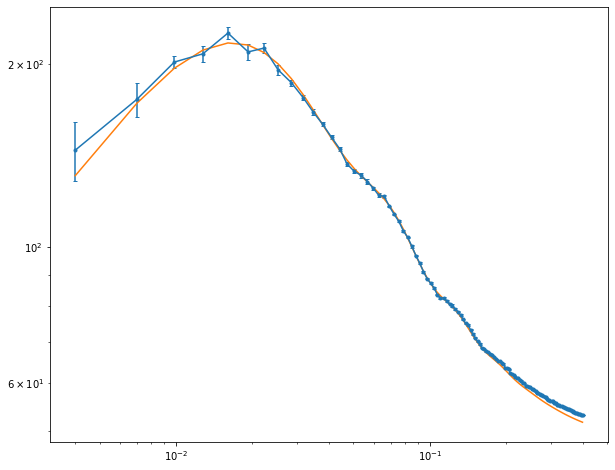

In [32]:
plt.figure(figsize=[10,8]);
plt.errorbar(ksim,powsim, yerr=sigmapow, marker='o', ms=3, capsize=2, label='sim' );
plt.plot(ksim,simulator(medlist));
plt.xscale('log');
plt.yscale('log'); 

In [33]:
swyft.cred1d(res[-1],x0)

z0 = 2.10081 +- 0.01564
z1 = 0.50134 +- 0.47662
z2 = 1.22400 +- 0.41167
z3 = -3.89361 +- 0.88127
z4 = 0.34574 +- 1.28524
z5 = -0.13716 +- 0.04432
z6 = 0.16834 +- 0.04012


In [34]:
for i in range(2):
    if intensity is None:
        #intensity = swyft.get_unit_intensity(
        #    expected_n=EXPECTED_N, 
        #    dim=zdim
        #)
        intensity=Intensity(EXPECTED_N,iFM)
    else:
        intensity = swyft.get_constrained_intensity(
            expected_n=80000,
            ratio_estimator=re,
            x0=x0,
            threshold=1e-4,
        )
    
    cache.grow(intensity)
    cache.simulate(simulator)
    
    points = swyft.Points(cache, intensity, noise)
    
    statistics = swyft.get_statistics(points)
    re = swyft.RatioEstimator(
        points, 
        device=DEVICE, 
        statistics=statistics, head=Head(), previous_ratio_estimator=pre
    )
    res.append(re)
    res[-1].train(
        max_epochs=MAX_EPOCHS, 
        batch_size=32, 
        lr_schedule=[1e-3, 3e-4, 1e-4],
        early_stopping_patience=2
    )
    pre = res[-1]

Constrained posterior area: 20.80676498103054


Simulate:   0%|          | 239/68974 [00:00<00:28, 2387.33it/s]

Adding 68974 new samples. Run simulator!


Simulate: 100%|██████████| 68974/68974 [00:29<00:00, 2365.45it/s]


No new simulator runs required.


/var/scratch/aecole/miniconda3/lib/python3.8/site-packages/swyft/estimation.py:91: UserWarning: using previous ratio estimator's head rather than yours.
  warn("using previous ratio estimator's head rather than yours.")


yshape (shape of features between head and legs): 560
Start training
LR iteration 0
Validation loss: 3694.6024103164673
Validation loss: 3557.6449995040894
Validation loss: 3529.422501564026
Validation loss: 3495.0203256607056
Validation loss: 3489.941867828369
Validation loss: 3474.535557746887
Validation loss: 3437.835247039795
Validation loss: 3471.2801446914673
Validation loss: 3442.5082845687866
Total epochs: 9
LR iteration 1
Validation loss: 3359.0231018066406
Validation loss: 3355.0588941574097
Validation loss: 3320.953598022461
Validation loss: 3343.488914489746
Validation loss: 3334.783208847046
Total epochs: 5
LR iteration 2
Validation loss: 3312.8786783218384
Validation loss: 3316.804341316223
Validation loss: 3297.1001358032227
Validation loss: 3300.37704372406
Validation loss: 3307.3654232025146
Total epochs: 5
Constrained posterior area: 12.86005784542266


Simulate:   1%|          | 238/30555 [00:00<00:12, 2376.02it/s]

Adding 30555 new samples. Run simulator!


Simulate: 100%|██████████| 30555/30555 [00:12<00:00, 2374.89it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 560
Start training
LR iteration 0
Validation loss: 3653.0077838897705
Validation loss: 3610.594715118408
Validation loss: 3554.415428161621
Validation loss: 3514.4817323684692
Validation loss: 3496.9721879959106
Validation loss: 3503.612784385681
Validation loss: 3460.657628059387
Validation loss: 3460.2795362472534
Validation loss: 3470.646056175232
Validation loss: 3439.2480669021606
Validation loss: 3442.404644012451
Validation loss: 3442.784115791321
Total epochs: 12
LR iteration 1
Validation loss: 3372.0832509994507
Validation loss: 3362.146011352539
Validation loss: 3361.750931739807
Validation loss: 3363.576256752014
Validation loss: 3358.5882263183594
Validation loss: 3378.717755317688
Validation loss: 3363.986798286438
Total epochs: 7
LR iteration 2
Validation loss: 3345.130778312683
Validation loss: 3321.2497940063477
Validation loss: 3337.999336242676
Validation loss: 3328.4434852600098
Total e

In [37]:
cache.__len__()

222617

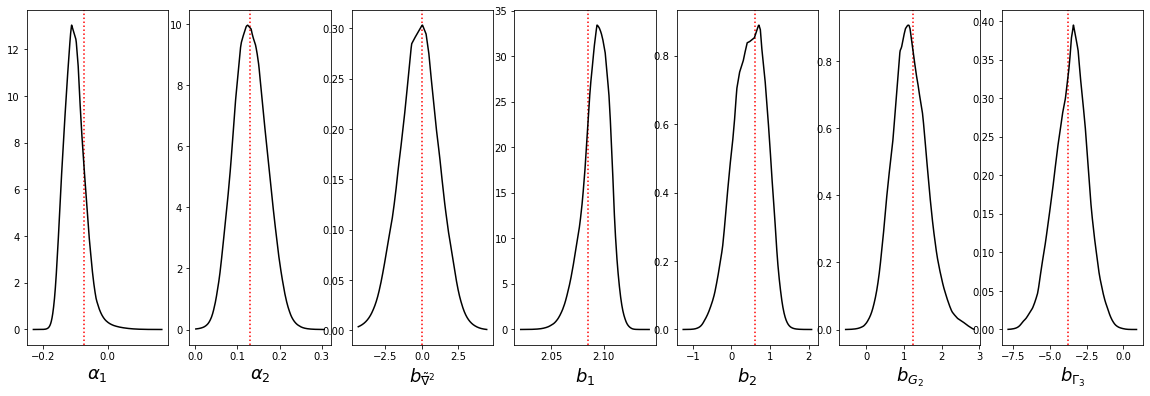

In [35]:
plot1d(res[-1], x0 = x0,
       z0 = np.array([2.08471636,0.60472895,1.23511048,-3.74206224,-7.8578e-06,-0.07530319,0.12946018]),
       params=params, labels=labelsordered,
             cmap = 'Greys', dims = (20,6),max_n_points=10000);
plt.savefig('LSSPS-1d.png');

In [36]:
swyft.cred1d(res[-1],x0)

z0 = 2.09377 +- 0.01214
z1 = 0.48676 +- 0.42975
z2 = 1.13336 +- 0.44579
z3 = -3.51798 +- 1.10638
z4 = -0.17048 +- 1.32617
z5 = -0.10514 +- 0.03157
z6 = 0.12952 +- 0.03897


In [38]:
medlist=[]
for i in range(res[-1].zdim):
    z, p = re.posterior(x0, i)
    medlist.append(get_stats(z, p)['median'])
    #print("z%i = %.5f +- %.5f" % (i, res["median"], res["err68"]))

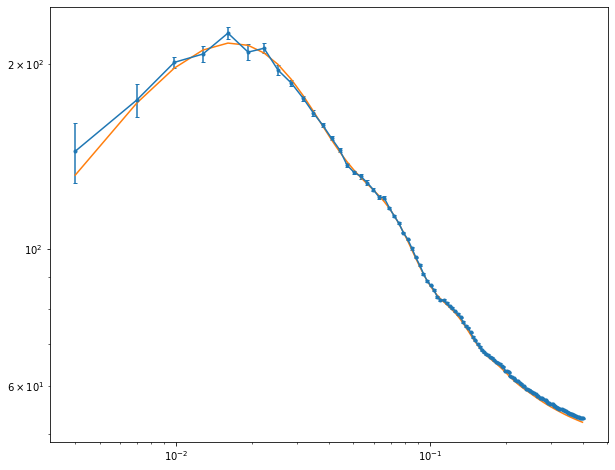

In [39]:
plt.figure(figsize=[10,8]);
plt.errorbar(ksim,powsim, yerr=sigmapow, marker='o', ms=3, capsize=2, label='sim' );
plt.plot(ksim,simulator(medlist));
plt.xscale('log');
plt.yscale('log'); 

In [40]:
combinations_2d = [[0, 1], [0, 2], [0,3],[0,4],[0,5],[0,6],
                  [1,2],[1,3],[1,4],[1,5],[1,6],
                  [2,3],[2,4],[2,5],[2,6],
                  [3,4],[3,5],[3,6],
                  [4,5],[4,6],
                  [5,6]]
statistics = swyft.get_statistics(points, combinations_2d)
re2 = swyft.RatioEstimator(
    points, 
    combinations=combinations_2d, 
    device=DEVICE, 
    statistics=statistics,head=Head()
)

yshape (shape of features between head and legs): 560


In [41]:
re2.train(max_epochs=MAX_EPOCHS, batch_size=32, lr_schedule=[1e-3, 3e-4], early_stopping_patience=1)

Start training
LR iteration 0
Validation loss: 8915.53970527649
Validation loss: 8039.319627761841
Validation loss: 7666.668928146362
Validation loss: 7407.93995475769
Validation loss: 7167.97056388855
Validation loss: 7092.227167129517
Validation loss: 6823.272357940674
Validation loss: 6766.676723480225
Validation loss: 6749.086664199829
Validation loss: 6700.504814147949
Validation loss: 6573.46075630188
Validation loss: 6638.476564407349
Total epochs: 12
LR iteration 1
Validation loss: 6342.596723556519
Validation loss: 6220.905113220215
Validation loss: 6219.464309692383
Validation loss: 6211.125898361206
Validation loss: 6209.000093460083
Validation loss: 6205.802688598633


KeyboardInterrupt: 

In [52]:
def corner(
    re1d,
    re2d,
    x0,
    dim = 10,
    params = None,
    labels = None,
    z0= None,
    cmap="Greys",
    max_n_points = 1000,
    fontsize=18
) -> None:
    # TODO: Rewrite
    if params is None:
        params = range(re1d.zdim)

    K = len(params)
    fig, axes = plt.subplots(K, K, figsize=(dim, dim))
    lb = 0.125
    tr = 0.9
    whspace = 0.1
    fig.subplots_adjust(
        left=lb, bottom=lb, right=tr, top=tr, wspace=whspace, hspace=whspace
    )

    if labels is None:
        labels = ["z%i" % params[i] for i in range(K)]
    for i in range(K):
        for j in range(K):
            ax = axes[i, j]
            # Switch off upper left triangle
            if i < j:
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_frame_on(False)
                continue

            # Formatting labels
            if j > 0 or i == 0:
                ax.set_yticklabels([])
                # ax.set_yticks([])
            if i < K - 1:
                ax.set_xticklabels([])
                # ax.set_xticks([])
            if i == K - 1:
                ax.set_xlabel(labels[j],fontsize=fontsize)
            if j == 0 and i > 0:
                ax.set_ylabel(labels[i],fontsize=fontsize)

            # Set limits
            # ax.set_xlim(x_lims[j])
            # if i != j:
            #    ax.set_ylim(y_lims[i])

            # 2-dim plots
            if j < i:
                swyft.plot.cont2d(
                    ax,
                    re2d,
                    x0,
                    z0,
                    np.min([params[j],params[i]]),
                    np.max([params[j],params[i]]),
                    cmap=cmap,
                    max_n_points=max_n_points,
                )

            if j == i:
                swyft.plot.hist1d(ax, re1d, x0, z0, params[i], max_n_points=max_n_points)

In [43]:
cache.__len__()

222617

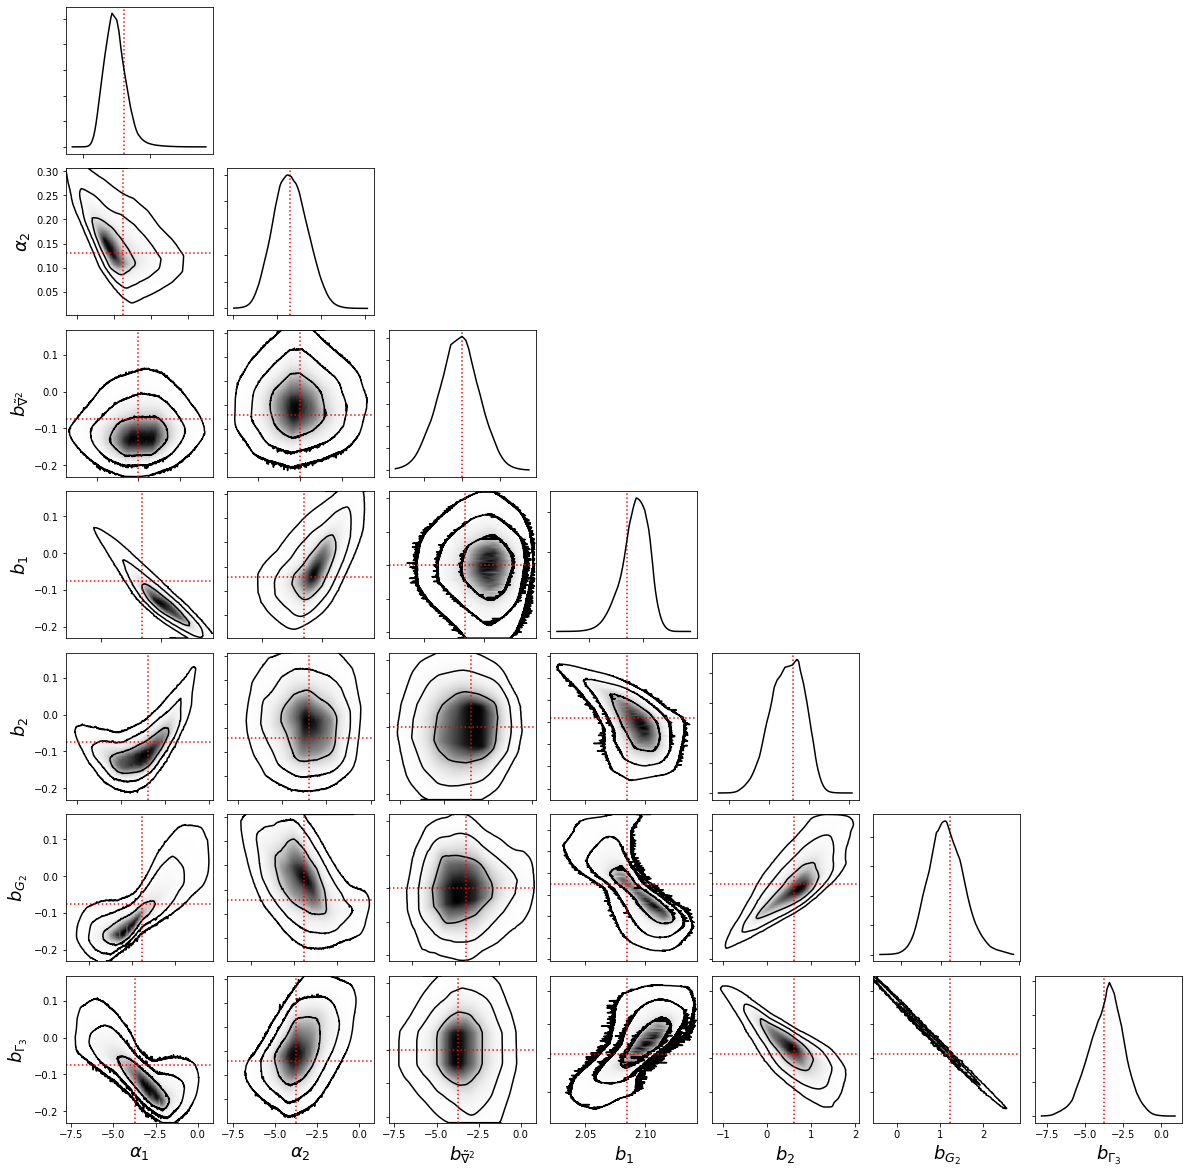

In [54]:
corner(re, re2, x0 = x0, cmap = 'Greys', dim = 20, max_n_points=20000,
      z0 = np.array([2.08471636,0.60472895,1.23511048,-3.74206224,-7.8578e-06,-0.07530319,0.12946018]),
       params=params, labels=labelsordered)
plt.savefig('LSS-PSCorner.png')

see if more training moves the modes for $b_1$ and $\alpha_1$

In [55]:
for i in range(1):
    if intensity is None:
        #intensity = swyft.get_unit_intensity(
        #    expected_n=EXPECTED_N, 
        #    dim=zdim
        #)
        intensity=Intensity(EXPECTED_N,iFM)
    else:
        intensity = swyft.get_constrained_intensity(
            expected_n=100000,
            ratio_estimator=re,
            x0=x0,
            threshold=1e-4,
        )
    
    cache.grow(intensity)
    cache.simulate(simulator)
    
    points = swyft.Points(cache, intensity, noise)
    
    statistics = swyft.get_statistics(points)
    re = swyft.RatioEstimator(
        points, 
        device=DEVICE, 
        statistics=statistics, head=Head(), previous_ratio_estimator=pre
    )
    res.append(re)
    res[-1].train(
        max_epochs=MAX_EPOCHS, 
        batch_size=32, 
        lr_schedule=[1e-3, 3e-4, 1e-4],
        early_stopping_patience=2
    )
    pre = res[-1]

Constrained posterior area: 8.454537047868426


Simulate:   0%|          | 234/47245 [00:00<00:20, 2337.41it/s]

Adding 47245 new samples. Run simulator!


Simulate: 100%|██████████| 47245/47245 [00:19<00:00, 2364.93it/s]


No new simulator runs required.


/var/scratch/aecole/miniconda3/lib/python3.8/site-packages/swyft/estimation.py:91: UserWarning: using previous ratio estimator's head rather than yours.
  warn("using previous ratio estimator's head rather than yours.")


yshape (shape of features between head and legs): 560
Start training
LR iteration 0
Validation loss: 4538.138878822327
Validation loss: 4463.7145166397095
Validation loss: 4400.554733276367
Validation loss: 4356.375020980835
Validation loss: 4370.131141662598
Validation loss: 4343.004455566406
Validation loss: 4308.1565799713135
Validation loss: 4372.016743659973
Validation loss: 4318.610733032227
Total epochs: 9
LR iteration 1
Validation loss: 4222.64364528656
Validation loss: 4242.1760721206665
Validation loss: 4210.689193725586
Validation loss: 4202.57234954834
Validation loss: 4212.893779754639
Validation loss: 4205.88401889801
Total epochs: 6
LR iteration 2
Validation loss: 4190.261616706848
Validation loss: 4170.8487758636475
Validation loss: 4175.2066831588745
Validation loss: 4178.686282157898
Total epochs: 4


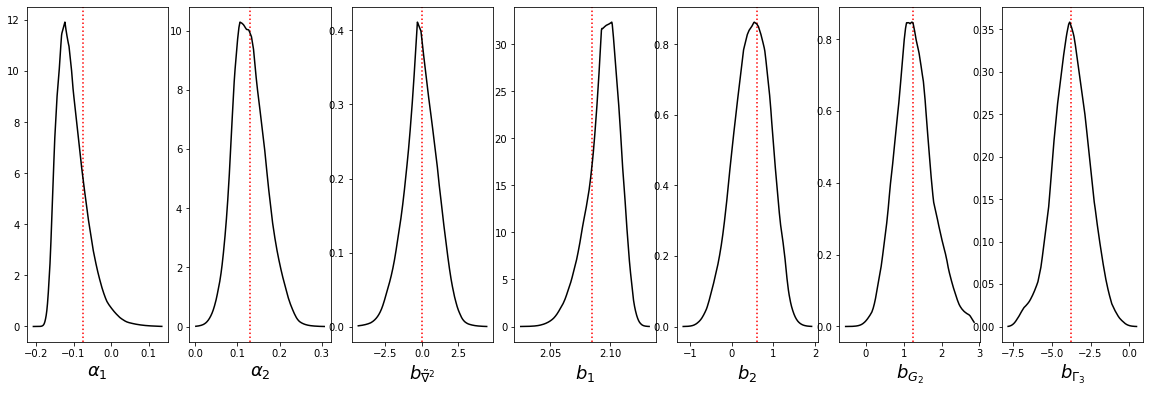

In [57]:
plot1d(res[-1], x0 = x0,
       z0 = np.array([2.08471636,0.60472895,1.23511048,-3.74206224,-7.8578e-06,-0.07530319,0.12946018]),
       params=params, labels=labelsordered,
             cmap = 'Greys', dims = (20,6),max_n_points=10000);
#plt.savefig('LSSPS-1d.png');

In [59]:
res[-1].train(
    max_epochs=MAX_EPOCHS, 
    batch_size=32, 
    lr_schedule=[5e-5],
    early_stopping_patience=2
)
pre = res[-1]

Start training
LR iteration 0
Validation loss: 4219.437841415405
Validation loss: 4214.01513004303
Validation loss: 4212.401944160461
Validation loss: 4211.141421318054
Validation loss: 4203.3372621536255
Validation loss: 4222.793273925781
Validation loss: 4213.92582321167
Total epochs: 7


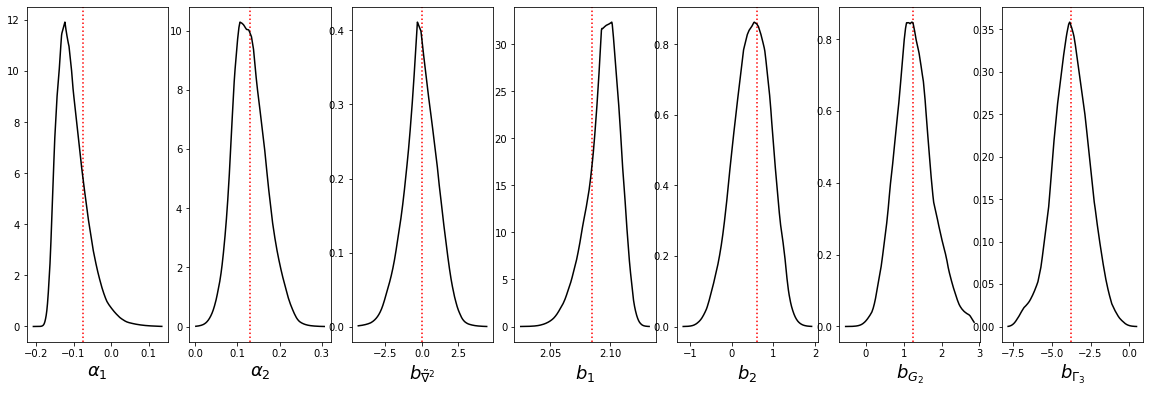

In [60]:
plot1d(res[-1], x0 = x0,
       z0 = np.array([2.08471636,0.60472895,1.23511048,-3.74206224,-7.8578e-06,-0.07530319,0.12946018]),
       params=params, labels=labelsordered,
             cmap = 'Greys', dims = (20,6),max_n_points=10000);
#plt.savefig('LSSPS-1d.png');

In [61]:
medlist=[]
for i in range(res[-1].zdim):
    z, p = re.posterior(x0, i)
    medlist.append(get_stats(z, p)['median'])
    #print("z%i = %.5f +- %.5f" % (i, res["median"], res["err68"]))

try playing around with decreasing $b_1$ and increasing $\alpha_1$

In [63]:
medlist

[2.095904009115684,
 0.49845048229628425,
 1.234433348953872,
 -3.770626517268863,
 -0.0704385211783233,
 -0.10973185419801253,
 0.12638172726908303]

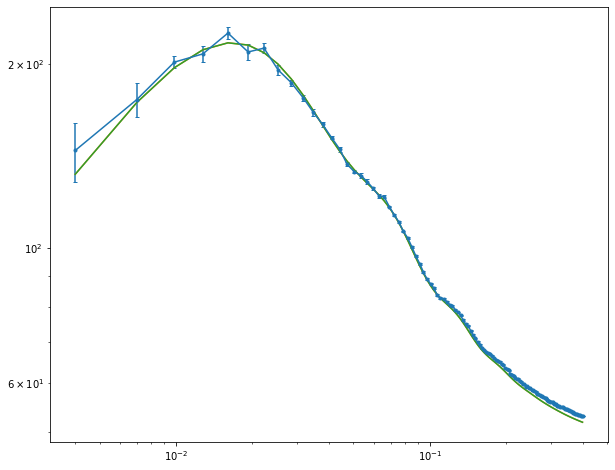

In [70]:
plt.figure(figsize=[10,8]);
plt.errorbar(ksim,powsim, yerr=sigmapow, marker='o', ms=3, capsize=2, label='sim' );
plt.plot(ksim,simulator(medlist));
plt.plot(ksim,simulator(np.array(medlist)+np.array([-0.0,0,0,0,0,0.01,0])))
plt.xscale('log');
plt.yscale('log'); 

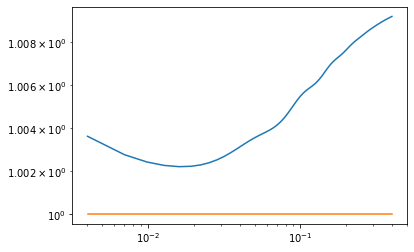

In [75]:
plt.plot(ksim,simulator(np.array(medlist)+np.array([0,0,0,0,0,0.01,0]))/simulator(medlist));
plt.plot(ksim, np.ones(len(ksim)));
plt.xscale('log');
plt.yscale('log');

In [ ]:
res[-1].train(
    max_epochs=MAX_EPOCHS, 
    batch_size=32, 
    lr_schedule=[3e-5,1e-5],
    early_stopping_patience=3
)
pre = res[-1]

Start training
LR iteration 0
Validation loss: 4199.603715896606
Validation loss: 4212.600168228149
Validation loss: 4217.3144636154175
Validation loss: 4201.363595962524
Total epochs: 4
LR iteration 1
Validation loss: 4195.674855232239
Validation loss: 4204.7840003967285
Validation loss: 4210.186820030212


In [ ]:
plot1d(res[-1], x0 = x0,
       z0 = np.array([2.08471636,0.60472895,1.23511048,-3.74206224,-7.8578e-06,-0.07530319,0.12946018]),
       params=params, labels=labelsordered,
             cmap = 'Greys', dims = (20,6),max_n_points=10000);
#plt.savefig('LSSPS-1d.png');

# Headless attempt

In [10]:
DEVICE = 'cuda:0'
MAX_EPOCHS = 100
EXPECTED_N = 10000

hack for get custom flat prior

In [11]:
iFM=FactorMask([Mask1d([elm]) for elm in [[0.01,10.0],[-10.0,10.0],[-10.0,10.0],[-10.0,10.0],\
                                     [-100.0,100.0],[-1.0,1.0],[-10.0,10.0]]])

In [12]:
cache = swyft.MemoryCache(zdim = zdim, xshape = x0.shape)

Creating new cache.


In [13]:
res=[]

In [14]:
intensity = None
pre = None
for i in range(8):
    if intensity is None:
        #intensity = swyft.get_unit_intensity(
        #    expected_n=EXPECTED_N, 
        #    dim=zdim
        #)
        intensity=Intensity(EXPECTED_N,iFM)
    else:
        intensity = swyft.get_constrained_intensity(
            expected_n=EXPECTED_N,
            ratio_estimator=re,
            x0=x0,
            threshold=1e-4,
        )
    
    cache.grow(intensity)
    cache.simulate(simulator)
    
    points = swyft.Points(cache, intensity, noise)
    
    statistics = swyft.get_statistics(points)
    re = swyft.RatioEstimator(
        points, 
        device=DEVICE, 
        statistics=statistics, head=None, previous_ratio_estimator=pre
    )
    res.append(re)
    res[-1].train(
        max_epochs=MAX_EPOCHS, 
        batch_size=32, 
        lr_schedule=[1e-3, 3e-4, 1e-4],
        early_stopping_patience=2
    )
    pre = res[-1]

Simulate:   2%|▏         | 162/10019 [00:00<00:06, 1619.85it/s]

Adding 10019 new samples. Run simulator!


Simulate: 100%|██████████| 10019/10019 [00:04<00:00, 2183.20it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 127
Start training
LR iteration 0
Validation loss: 558.9385757446289
Validation loss: 526.5700798034668
Validation loss: 524.142068862915
Validation loss: 518.3993339538574
Validation loss: 518.6879787445068
Validation loss: 510.9357261657715
Validation loss: 511.4319829940796
Validation loss: 508.6425943374634
Validation loss: 504.79897022247314
Validation loss: 500.84752655029297
Validation loss: 501.79770278930664
Validation loss: 495.1766023635864
Validation loss: 492.83115005493164
Validation loss: 491.54608726501465
Validation loss: 498.6876029968262
Validation loss: 489.15741062164307
Validation loss: 489.90638065338135
Validation loss: 488.5196237564087
Validation loss: 487.752947807312
Validation loss: 483.0760545730591
Validation loss: 483.33623218536377
Validation loss: 485.30815029144287
Total epochs: 22
LR iteration 1
Validation loss: 473.5515899658203
Validation loss: 473.0230960845947
Valid

Simulate:   3%|▎         | 231/8565 [00:00<00:03, 2302.37it/s]

Constrained posterior area: 76418373.19862655
Adding 8565 new samples. Run simulator!


Simulate: 100%|██████████| 8565/8565 [00:04<00:00, 2114.80it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 127
Start training
LR iteration 0
Validation loss: 538.7072219848633
Validation loss: 527.9128170013428
Validation loss: 513.3646144866943
Validation loss: 511.6607360839844
Validation loss: 505.61718463897705
Validation loss: 503.16673278808594
Validation loss: 498.73816299438477
Validation loss: 489.99635124206543
Validation loss: 488.64564037323
Validation loss: 482.77584743499756
Validation loss: 487.1283988952637
Validation loss: 485.81621742248535
Total epochs: 12
LR iteration 1
Validation loss: 470.67390155792236
Validation loss: 475.3119230270386
Validation loss: 468.3076286315918
Validation loss: 465.5524206161499
Validation loss: 456.47437858581543
Validation loss: 451.11616230010986
Validation loss: 443.9712333679199
Validation loss: 442.0726537704468
Validation loss: 439.65597915649414
Validation loss: 433.3208284378052
Validation loss: 430.82106494903564
Validation loss: 431.2531623840332
Val

Simulate:   3%|▎         | 239/8421 [00:00<00:03, 2384.05it/s]

Constrained posterior area: 10980337.14446973
Adding 8421 new samples. Run simulator!


Simulate: 100%|██████████| 8421/8421 [00:03<00:00, 2352.58it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 127
Start training
LR iteration 0
Validation loss: 528.4250030517578
Validation loss: 507.8420343399048
Validation loss: 506.35073947906494
Validation loss: 492.1984004974365
Validation loss: 484.303861618042
Validation loss: 483.43110179901123
Validation loss: 484.8897247314453
Validation loss: 474.0337371826172
Validation loss: 479.158390045166
Validation loss: 470.7698984146118
Validation loss: 461.8345699310303
Validation loss: 456.1929168701172
Validation loss: 465.9995632171631
Validation loss: 463.6910514831543
Total epochs: 14
LR iteration 1
Validation loss: 440.90582180023193
Validation loss: 440.38609313964844
Validation loss: 438.88254261016846
Validation loss: 438.83573818206787
Validation loss: 430.0035104751587
Validation loss: 430.5943298339844
Validation loss: 428.4237861633301
Validation loss: 427.27520847320557
Validation loss: 430.20209312438965
Validation loss: 432.7940912246704
Total 

Simulate:   4%|▍         | 238/5997 [00:00<00:02, 2374.43it/s]

Constrained posterior area: 4405870.514536324
Adding 5997 new samples. Run simulator!


Simulate: 100%|██████████| 5997/5997 [00:02<00:00, 2309.81it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 127
Start training
LR iteration 0


KeyboardInterrupt: 

In [36]:
labels=['$b_1$','$b_2$','$b_{G_2}$','$b_{\\Gamma_3}$','$b_{\\tilde{\\nabla}^2}$', '$\\alpha_1$','$\\alpha_2$']

In [37]:
params=[5,6,4,0,1,2,3]

In [38]:
labelsordered=np.array(labels)[params]

In [19]:
def plot1d(
    re1d,
    x0=None,
    dims = (15, 5),
    ncol= None,
    params=None,
    labels = None,
    z0= None,
    cmap= "Greys",
    max_n_points = 1000,
    fontsize=18
):
    # TODO: Rewrite
    if params is None:
        params = range(re1d.zdim)

    if ncol is None:
        ncol = re1d.zdim

    K = len(params)
    nrow = (K - 1) // ncol + 1

    fig, axes = plt.subplots(nrow, ncol, figsize=dims)
    lb = 0.125
    tr = 0.9
    whspace = 0.15
    fig.subplots_adjust(
        left=lb, bottom=lb, right=tr, top=tr, wspace=whspace, hspace=whspace
    )

    if labels is None:
        labels = ["z%i" % params[i] for i in range(K)]
    for k in range(K):
        if nrow == 1:
            ax = axes[k]
        else:
            i, j = k % ncol, k // ncol
            ax = axes[j, i]
        swyft.plot.hist1d(ax, re1d, x0, z0, params[k], max_n_points=max_n_points)
        ax.set_xlabel(labels[k], fontsize=fontsize)

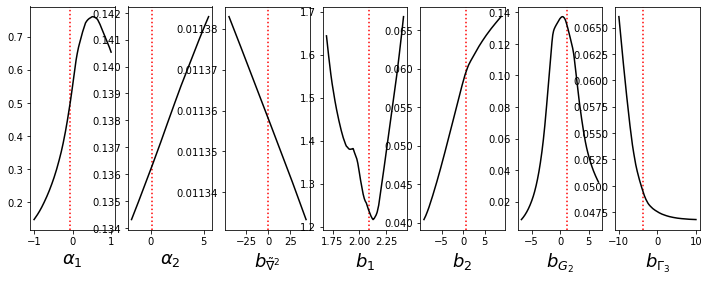

In [41]:
plot1d(res[-1], x0 = x0,
       z0 = np.array([2.08471636,0.60472895,1.23511048,-3.74206224,-7.8578e-06,-0.07530319,0.12946018]),
       params=params, labels=labelsordered,
             cmap = 'Greys', dims = (12, 4),max_n_points=10000);

In [22]:
for i in range(4):
    if intensity is None:
        #intensity = swyft.get_unit_intensity(
        #    expected_n=EXPECTED_N, 
        #    dim=zdim
        #)
        intensity=Intensity(EXPECTED_N,iFM)
    else:
        intensity = swyft.get_constrained_intensity(
            expected_n=EXPECTED_N,
            ratio_estimator=re,
            x0=x0,
            threshold=1e-4,
        )
    
    cache.grow(intensity)
    cache.simulate(simulator)
    
    points = swyft.Points(cache, intensity, noise)
    
    statistics = swyft.get_statistics(points)
    re = swyft.RatioEstimator(
        points, 
        device=DEVICE, 
        statistics=statistics, head=None, previous_ratio_estimator=pre
    )
    res.append(re)
    res[-1].train(
        max_epochs=MAX_EPOCHS, 
        batch_size=32, 
        lr_schedule=[1e-3, 3e-4, 1e-4],
        early_stopping_patience=2
    )
    pre = res[-1]

Simulate:   7%|▋         | 237/3339 [00:00<00:01, 2366.20it/s]

Constrained posterior area: 398978966.9847077
Adding 3339 new samples. Run simulator!


Simulate: 100%|██████████| 3339/3339 [00:01<00:00, 2344.46it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 127
Start training
LR iteration 0
Validation loss: 546.284423828125
Validation loss: 528.7748775482178
Validation loss: 521.7992000579834
Validation loss: 512.5158061981201
Validation loss: 504.4202127456665
Validation loss: 508.57822704315186
Validation loss: 497.20865535736084
Validation loss: 497.341570854187
Validation loss: 489.1434745788574
Validation loss: 489.9247465133667
Validation loss: 491.8837661743164
Total epochs: 11
LR iteration 1
Validation loss: 481.7524709701538
Validation loss: 482.9065647125244
Validation loss: 479.28754138946533
Validation loss: 474.5993480682373
Validation loss: 467.255952835083
Validation loss: 457.1606636047363
Validation loss: 450.36021423339844
Validation loss: 446.01332092285156
Validation loss: 442.03360080718994
Validation loss: 439.9653549194336
Validation loss: 438.3640384674072
Validation loss: 433.29679584503174
Validation loss: 430.5533170700073
Validati

Simulate:   7%|▋         | 238/3222 [00:00<00:01, 2371.94it/s]

Constrained posterior area: 28889550.875184074
Adding 3222 new samples. Run simulator!


Simulate: 100%|██████████| 3222/3222 [00:01<00:00, 2312.14it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 127
Start training
LR iteration 0
Validation loss: 542.2320461273193
Validation loss: 518.5456590652466
Validation loss: 505.46810722351074
Validation loss: 500.0694875717163
Validation loss: 498.7991352081299
Validation loss: 483.90674591064453
Validation loss: 480.79617977142334
Validation loss: 474.8088684082031
Validation loss: 467.26064109802246
Validation loss: 474.08369159698486
Validation loss: 474.8731441497803
Total epochs: 11
LR iteration 1
Validation loss: 454.4858179092407
Validation loss: 449.6463975906372
Validation loss: 445.0747661590576
Validation loss: 445.0885343551636
Validation loss: 443.04304790496826
Validation loss: 439.4787302017212
Validation loss: 438.3309450149536
Validation loss: 436.6993532180786
Validation loss: 425.4160432815552
Validation loss: 433.2595691680908
Validation loss: 428.0779781341553
Total epochs: 11
LR iteration 2
Validation loss: 420.2555093765259
Validatio

Simulate:   0%|          | 0/2004 [00:00<?, ?it/s]

Constrained posterior area: 7366582.392180242
Adding 2004 new samples. Run simulator!


Simulate: 100%|██████████| 2004/2004 [00:00<00:00, 2297.53it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 127
Start training
LR iteration 0
Validation loss: 522.4755744934082
Validation loss: 504.0302562713623
Validation loss: 493.87392711639404
Validation loss: 490.5505542755127
Validation loss: 488.03117752075195
Validation loss: 487.87333965301514
Validation loss: 475.64239597320557
Validation loss: 472.7509469985962
Validation loss: 475.3535280227661
Validation loss: 468.90380096435547
Validation loss: 463.53302669525146
Validation loss: 464.0394620895386
Validation loss: 457.08376026153564
Validation loss: 462.8482074737549
Validation loss: 455.51981353759766
Validation loss: 457.7384443283081
Validation loss: 451.2516746520996
Validation loss: 445.91503047943115
Validation loss: 441.83905696868896
Validation loss: 437.7474775314331
Validation loss: 438.2932758331299
Validation loss: 436.1126432418823
Validation loss: 430.61127758026123
Validation loss: 434.1672124862671
Validation loss: 434.591100692749

Simulate:   0%|          | 0/3527 [00:00<?, ?it/s]

Constrained posterior area: 2202855.2292926083
Adding 3527 new samples. Run simulator!


Simulate: 100%|██████████| 3527/3527 [00:01<00:00, 2382.00it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 127
Start training
LR iteration 0
Validation loss: 539.1421928405762
Validation loss: 519.1926975250244
Validation loss: 501.38004207611084
Validation loss: 503.36363220214844
Validation loss: 485.67076206207275
Validation loss: 485.0790853500366
Validation loss: 486.1516799926758
Validation loss: 481.8495979309082
Validation loss: 472.1728792190552
Validation loss: 473.7432861328125
Validation loss: 476.6335697174072
Total epochs: 11
LR iteration 1
Validation loss: 464.3113193511963
Validation loss: 460.4272403717041
Validation loss: 465.1453523635864
Validation loss: 464.2627077102661
Total epochs: 4
LR iteration 2
Validation loss: 456.8933048248291
Validation loss: 455.4309778213501
Validation loss: 454.44836807250977
Validation loss: 452.1122303009033
Validation loss: 452.2608823776245
Validation loss: 450.92749977111816
Validation loss: 448.7779893875122
Validation loss: 450.69408988952637
Validation

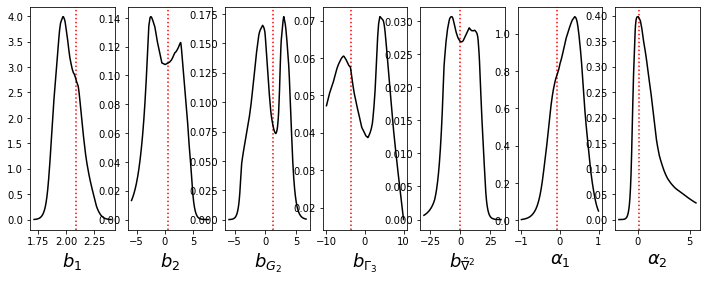

In [23]:
plot1d(res[-1], x0 = x0, z0 = [2.08471636,0.60472895,1.23511048,-3.74206224,-7.8578e-06,-0.07530319,0.12946018],
             cmap = 'Greys', dims = (12, 4),max_n_points=10000, labels=labels);

In [24]:
cache.__len__()

45573

In [26]:
for i in range(2):
    if intensity is None:
        #intensity = swyft.get_unit_intensity(
        #    expected_n=EXPECTED_N, 
        #    dim=zdim
        #)
        intensity=Intensity(EXPECTED_N,iFM)
    else:
        intensity = swyft.get_constrained_intensity(
            expected_n=20000,
            ratio_estimator=re,
            x0=x0,
            threshold=1e-4,
        )
    
    cache.grow(intensity)
    cache.simulate(simulator)
    
    points = swyft.Points(cache, intensity, noise)
    
    statistics = swyft.get_statistics(points)
    re = swyft.RatioEstimator(
        points, 
        device=DEVICE, 
        statistics=statistics, head=None, previous_ratio_estimator=pre
    )
    res.append(re)
    res[-1].train(
        max_epochs=MAX_EPOCHS, 
        batch_size=32, 
        lr_schedule=[1e-3, 3e-4, 1e-4],
        early_stopping_patience=3
    )
    pre = res[-1]

Simulate:   0%|          | 0/24 [00:00<?, ?it/s]

Constrained posterior area: 2123045.513016285
Adding 24 new samples. Run simulator!


Simulate: 100%|██████████| 24/24 [00:00<00:00, 2179.19it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 127
Start training
LR iteration 0
Validation loss: 1051.4881992340088
Validation loss: 1045.7197694778442
Validation loss: 993.2418632507324
Validation loss: 967.0117235183716
Validation loss: 970.998384475708
Validation loss: 961.7333650588989
Validation loss: 955.0825529098511
Validation loss: 936.2990369796753
Validation loss: 937.6203670501709
Validation loss: 920.9721231460571
Validation loss: 924.902437210083
Validation loss: 918.2060394287109
Validation loss: 893.7458438873291
Validation loss: 903.2715501785278
Validation loss: 887.8838415145874
Validation loss: 890.9386701583862
Validation loss: 885.877631187439
Validation loss: 885.8977975845337
Validation loss: 873.1982946395874
Validation loss: 888.2859163284302
Validation loss: 876.2314558029175
Validation loss: 874.8552408218384
Total epochs: 22
LR iteration 1
Validation loss: 844.3170824050903
Validation loss: 838.2090549468994
Validation lo

Simulate: 100%|██████████| 14556/14556 [00:06<00:00, 2317.94it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 127
Start training
LR iteration 0
Validation loss: 1066.4988613128662
Validation loss: 1067.9749221801758
Validation loss: 1027.382375717163
Validation loss: 1004.4686346054077
Validation loss: 1005.6275262832642
Validation loss: 983.6453046798706
Validation loss: 996.375433921814
Validation loss: 968.5114002227783
Validation loss: 963.5862331390381
Validation loss: 962.4878568649292
Validation loss: 962.5488128662109
Validation loss: 954.3562965393066
Validation loss: 951.9255886077881
Validation loss: 957.8533525466919
Validation loss: 953.579047203064
Validation loss: 941.6321783065796
Validation loss: 932.9855785369873
Validation loss: 935.2263984680176
Validation loss: 934.5846376419067
Validation loss: 933.9237880706787
Total epochs: 20
LR iteration 1
Validation loss: 915.328929901123
Validation loss: 908.3526048660278
Validation loss: 912.3259563446045
Validation loss: 907.577657699585
Validation l

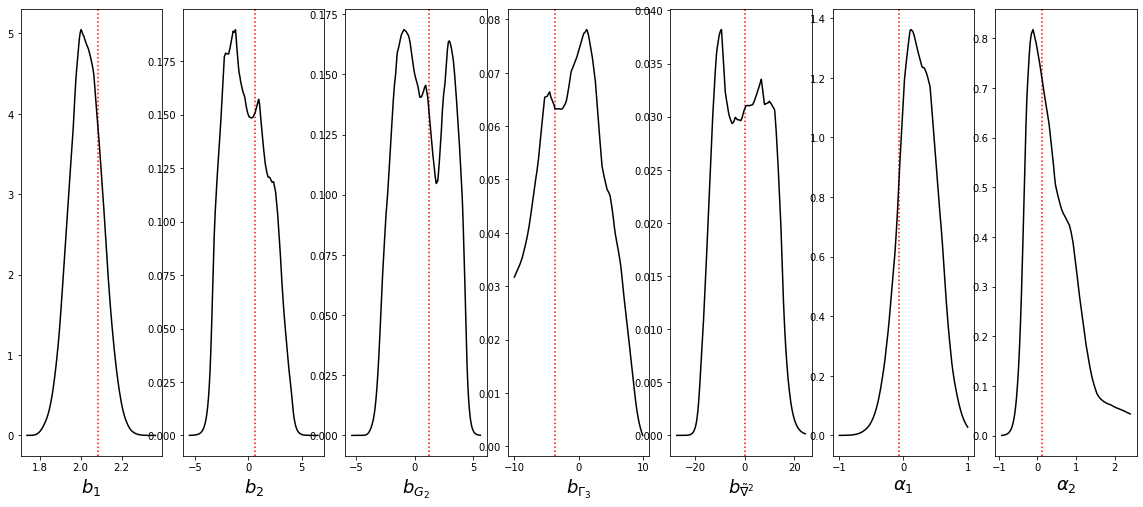

In [27]:
plot1d(res[-1],x0 = x0, z0 = [2.08471636,0.60472895,1.23511048,-3.74206224,-7.8578e-06,-0.07530319,0.12946018],
             cmap = 'Greys', dims = (20, 8),max_n_points=10000, labels=labels);

In [29]:
for i in range(2):
    if intensity is None:
        #intensity = swyft.get_unit_intensity(
        #    expected_n=EXPECTED_N, 
        #    dim=zdim
        #)
        intensity=Intensity(EXPECTED_N,iFM)
    else:
        intensity = swyft.get_constrained_intensity(
            expected_n=40000,
            ratio_estimator=re,
            x0=x0,
            threshold=1e-4,
        )
    
    cache.grow(intensity)
    cache.simulate(simulator)
    
    points = swyft.Points(cache, intensity, noise)
    
    statistics = swyft.get_statistics(points)
    re = swyft.RatioEstimator(
        points, 
        device=DEVICE, 
        statistics=statistics, head=None, previous_ratio_estimator=pre
    )
    res.append(re)
    res[-1].train(
        max_epochs=MAX_EPOCHS, 
        batch_size=32, 
        lr_schedule=[1e-3, 3e-4, 1e-4],
        early_stopping_patience=3
    )
    pre = res[-1]

Constrained posterior area: 418959.46959744254


Simulate:   1%|          | 222/25342 [00:00<00:11, 2215.10it/s]

Adding 25342 new samples. Run simulator!


Simulate: 100%|██████████| 25342/25342 [00:11<00:00, 2223.87it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 127
Start training
LR iteration 0
Validation loss: 2112.443652153015
Validation loss: 2034.4232950210571
Validation loss: 2045.2877073287964
Validation loss: 1957.074559211731
Validation loss: 1956.8425951004028
Validation loss: 1947.903618812561
Validation loss: 1927.1293907165527
Validation loss: 1914.3345441818237
Validation loss: 1921.6145601272583
Validation loss: 1901.9309539794922
Validation loss: 1911.6066417694092
Validation loss: 1894.4826917648315
Validation loss: 1883.9157934188843
Validation loss: 1889.5286436080933
Validation loss: 1860.6374111175537
Validation loss: 1843.2310609817505
Validation loss: 1855.3199262619019
Validation loss: 1846.3528137207031
Validation loss: 1825.6912508010864
Validation loss: 1821.7258977890015
Validation loss: 1830.4254598617554
Validation loss: 1806.7042665481567
Validation loss: 1818.55810546875
Validation loss: 1816.0588684082031
Validation loss: 1804.560

Simulate:   1%|          | 236/22306 [00:00<00:09, 2353.55it/s]

Adding 22306 new samples. Run simulator!


Simulate: 100%|██████████| 22306/22306 [00:09<00:00, 2326.51it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 127
Start training
LR iteration 0
Validation loss: 2121.7446451187134
Validation loss: 2065.884455680847
Validation loss: 2008.5755825042725
Validation loss: 1975.986367225647
Validation loss: 1964.7077722549438
Validation loss: 1937.9055242538452
Validation loss: 1954.9345417022705
Validation loss: 1955.0086879730225
Validation loss: 1913.9063367843628
Validation loss: 1912.2326440811157
Validation loss: 1932.9068984985352
Validation loss: 1908.9922714233398
Validation loss: 1896.5071659088135
Validation loss: 1927.1066122055054
Validation loss: 1898.0551958084106
Validation loss: 1899.9819116592407
Total epochs: 16
LR iteration 1
Validation loss: 1855.9504108428955
Validation loss: 1839.187560081482
Validation loss: 1835.1775331497192
Validation loss: 1836.4330730438232
Validation loss: 1820.315281867981
Validation loss: 1838.5867624282837
Validation loss: 1816.115089416504
Validation loss: 1817.0748834

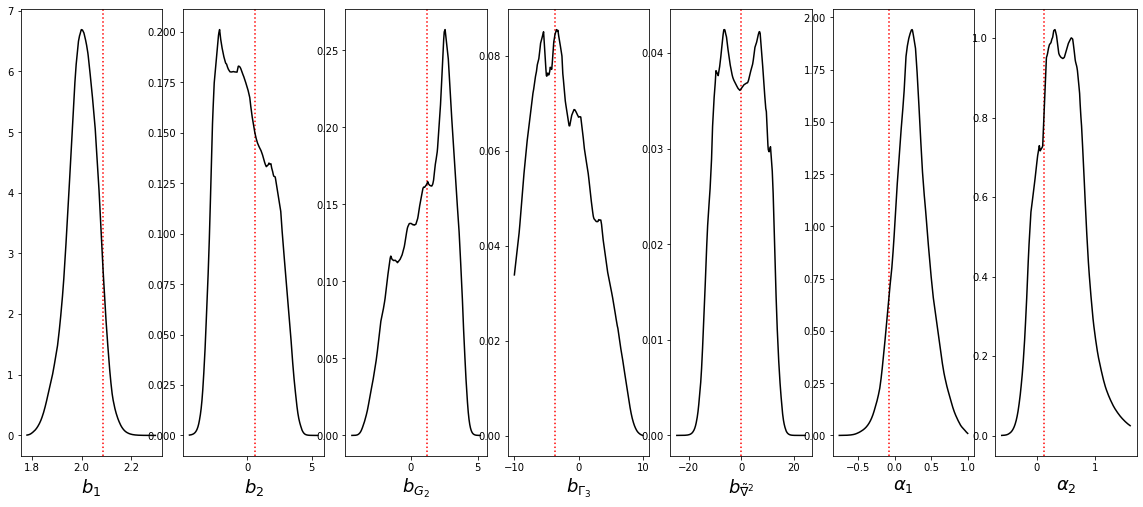

In [30]:
plot1d(res[-1],x0 = x0, z0 = [2.08471636,0.60472895,1.23511048,-3.74206224,-7.8578e-06,-0.07530319,0.12946018],
             cmap = 'Greys', dims = (20, 8),max_n_points=10000, labels=labels);

In [28]:
cache.__len__()

70673

In [46]:
from swyft.utils import get_stats

In [47]:
medlist=[]
for i in range(res[-1].zdim):
    z, p = re.posterior(x0, i)
    medlist.append(get_stats(z, p)['median'])
    #print("z%i = %.5f +- %.5f" % (i, res["median"], res["err68"]))

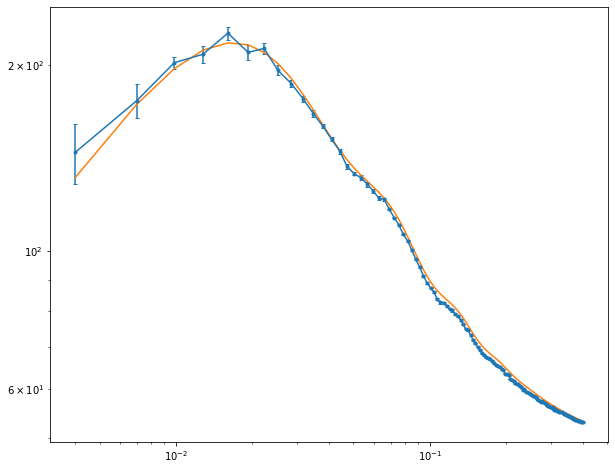

In [48]:
plt.figure(figsize=[10,8]);
plt.errorbar(ksim,powsim, yerr=sigmapow, marker='o', ms=3, capsize=2, label='sim' );
plt.plot(ksim,simulator(medlist));
plt.xscale('log');
plt.yscale('log'); 

In [49]:
swyft.cred1d(res[-1],x0)

z0 = 2.09625 +- 0.01519
z1 = 0.36579 +- 0.57647
z2 = 1.04492 +- 0.51676
z3 = -3.52807 +- 1.17776
z4 = -0.37601 +- 1.32150
z5 = -0.12166 +- 0.04138
z6 = 0.14437 +- 0.03696


In [58]:
for i in range(1):
    if intensity is None:
        #intensity = swyft.get_unit_intensity(
        #    expected_n=EXPECTED_N, 
        #    dim=zdim
        #)
        intensity=Intensity(EXPECTED_N,iFM)
    else:
        intensity = swyft.get_constrained_intensity(
            expected_n=80000,
            ratio_estimator=re,
            x0=x0,
            threshold=1e-4,
        )
    
    cache.grow(intensity)
    cache.simulate(simulator)
    
    points = swyft.Points(cache, intensity, noise)
    
    statistics = swyft.get_statistics(points)
    re = swyft.RatioEstimator(
        points, 
        device=DEVICE, 
        statistics=statistics, head=None, previous_ratio_estimator=pre
    )
    res.append(re)
    res[-1].train(
        max_epochs=MAX_EPOCHS, 
        batch_size=32, 
        lr_schedule=[1e-3, 3e-4, 1e-4],
        early_stopping_patience=3
    )
    pre = res[-1]

Constrained posterior area: 33.44704238541108


Simulate:   0%|          | 235/71170 [00:00<00:30, 2341.73it/s]

Adding 71170 new samples. Run simulator!


Simulate: 100%|██████████| 71170/71170 [00:30<00:00, 2352.69it/s]


No new simulator runs required.


/var/scratch/aecole/miniconda3/lib/python3.8/site-packages/swyft/estimation.py:91: UserWarning: using previous ratio estimator's head rather than yours.
  warn("using previous ratio estimator's head rather than yours.")


yshape (shape of features between head and legs): 560
Start training
LR iteration 0
Validation loss: 3743.790874481201
Validation loss: 3582.359888076782
Validation loss: 3617.4176959991455
Validation loss: 3476.6367807388306
Validation loss: 3476.3680152893066
Validation loss: 3412.371340751648
Validation loss: 3416.4038486480713
Validation loss: 3392.995388031006
Validation loss: 3379.6623821258545
Validation loss: 3359.6212453842163
Validation loss: 3376.0184688568115
Validation loss: 3374.645510673523
Validation loss: 3349.7361392974854
Validation loss: 3357.722026824951
Validation loss: 3351.1975021362305
Validation loss: 3343.725009918213
Validation loss: 3326.3461685180664
Validation loss: 3328.647910118103
Validation loss: 3332.6636991500854
Validation loss: 3337.4030199050903
Total epochs: 20
LR iteration 1
Validation loss: 3266.41348361969
Validation loss: 3248.88471698761
Validation loss: 3252.2983541488647
Validation loss: 3246.445411682129
Validation loss: 3250.48283481597

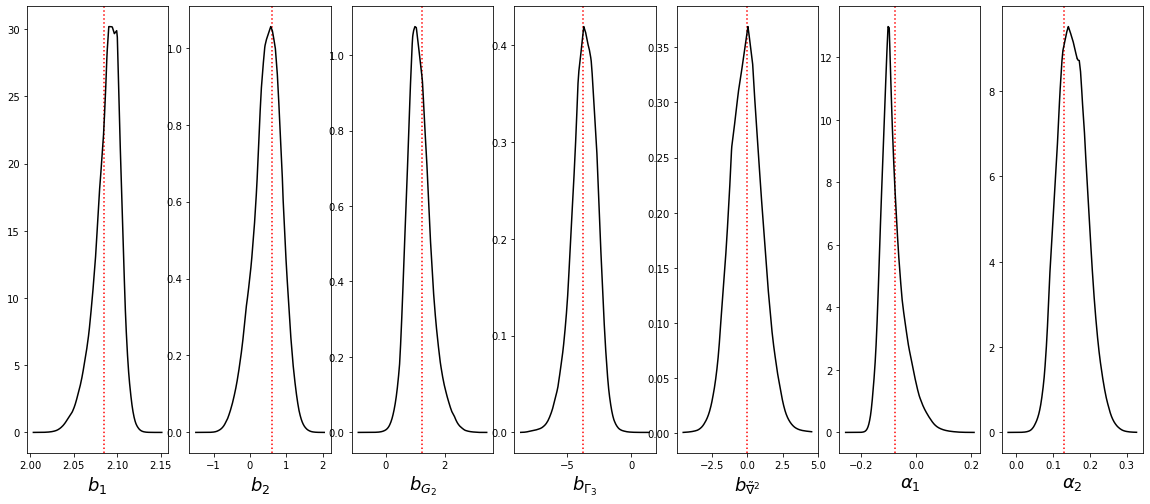

In [71]:
plot1d(res[-1],x0 = x0, z0 = [2.08471636,0.60472895,1.23511048,-3.74206224,-7.8578e-06,-0.07530319,0.12946018],
       cmap = 'Greys', dims = (20, 8),max_n_points=10000, labels=labels);
plt.savefig('LSSPS-1d.png');

In [73]:
for i in range(1):
    if intensity is None:
        #intensity = swyft.get_unit_intensity(
        #    expected_n=EXPECTED_N, 
        #    dim=zdim
        #)
        intensity=Intensity(EXPECTED_N,iFM)
    else:
        intensity = swyft.get_constrained_intensity(
            expected_n=80000,
            ratio_estimator=re,
            x0=x0,
            threshold=1e-4,
        )
    
    cache.grow(intensity)
    cache.simulate(simulator)
    
    points = swyft.Points(cache, intensity, noise)
    
    statistics = swyft.get_statistics(points)
    re = swyft.RatioEstimator(
        points, 
        device=DEVICE, 
        statistics=statistics, head=None, previous_ratio_estimator=pre
    )
    res.append(re)
    res[-1].train(
        max_epochs=MAX_EPOCHS, 
        batch_size=32, 
        lr_schedule=[1e-3, 3e-4, 1e-4],
        early_stopping_patience=2
    )
    pre = res[-1]

Constrained posterior area: 14.177004990213229


Simulate:   1%|          | 235/45846 [00:00<00:19, 2347.10it/s]

Adding 45846 new samples. Run simulator!


Simulate: 100%|██████████| 45846/45846 [00:19<00:00, 2319.66it/s]


No new simulator runs required.


/var/scratch/aecole/miniconda3/lib/python3.8/site-packages/swyft/estimation.py:91: UserWarning: using previous ratio estimator's head rather than yours.
  warn("using previous ratio estimator's head rather than yours.")


yshape (shape of features between head and legs): 560
Start training
LR iteration 0
Validation loss: 3665.8356466293335
Validation loss: 3575.273465156555
Validation loss: 3526.020977973938
Validation loss: 3507.0512495040894
Validation loss: 3502.854835510254
Validation loss: 3498.433491706848
Validation loss: 3470.6127700805664
Validation loss: 3483.0371046066284
Validation loss: 3440.5122213363647
Validation loss: 3456.151678085327
Validation loss: 3474.0562801361084
Total epochs: 11
LR iteration 1
Validation loss: 3377.4598426818848
Validation loss: 3368.1299142837524
Validation loss: 3365.930233001709
Validation loss: 3351.2024726867676
Validation loss: 3363.181981086731
Validation loss: 3381.375657081604
Total epochs: 6
LR iteration 2
Validation loss: 3345.8928575515747
Validation loss: 3342.735806465149
Validation loss: 3346.672643661499
Validation loss: 3351.5948543548584
Total epochs: 4


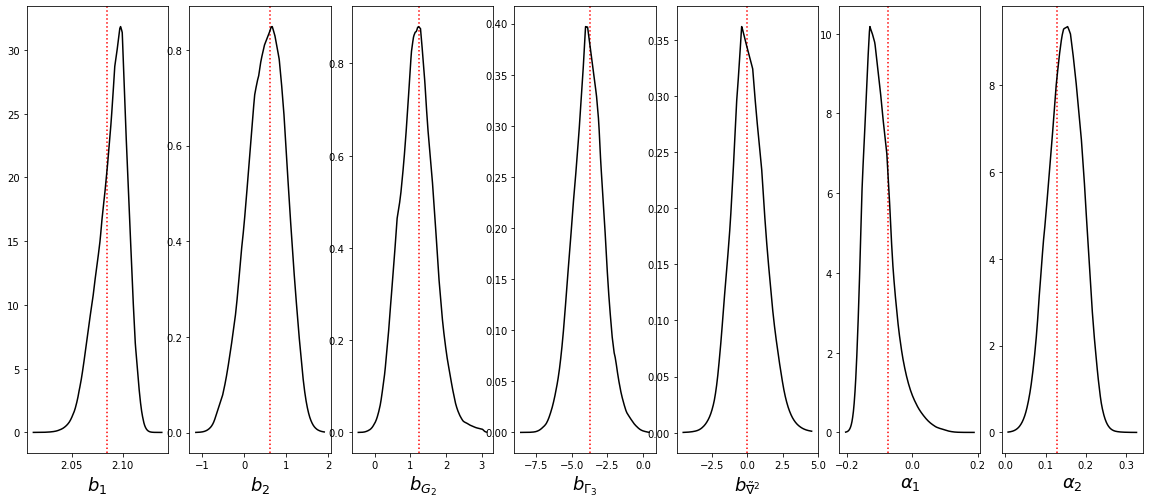

In [76]:
plot1d(res[-1],x0 = x0, z0 = [2.08471636,0.60472895,1.23511048,-3.74206224,-7.8578e-06,-0.07530319,0.12946018],
       cmap = 'Greys', dims = (20, 8),max_n_points=10000, labels=labels);
plt.savefig('LSSPS-1d.png');

In [75]:
swyft.cred1d(res[-1],x0)

z0 = 2.09183 +- 0.01437
z1 = 0.54182 +- 0.45630
z2 = 1.18839 +- 0.46923
z3 = -3.84937 +- 1.05625
z4 = 0.03295 +- 1.13628
z5 = -0.10728 +- 0.04157
z6 = 0.15032 +- 0.04173


In [61]:
combinations_2d = [[0, 1], [0, 2], [0,3],[0,4],[0,5],[0,6],
                  [1,2],[1,3],[1,4],[1,5],[1,6],
                  [2,3],[2,4],[2,5],[2,6],
                  [3,4],[3,5],[3,6],
                  [4,5],[4,6],
                  [5,6]]
statistics = swyft.get_statistics(points, combinations_2d)
re2 = swyft.RatioEstimator(
    points, 
    combinations=combinations_2d, 
    device=DEVICE, 
    statistics=statistics,head=Head()
)

yshape (shape of features between head and legs): 560


In [63]:
re2.train(max_epochs=MAX_EPOCHS, batch_size=32, lr_schedule=[1e-3, 3e-4], early_stopping_patience=1)

Start training
LR iteration 0
Validation loss: 8656.606506347656
Validation loss: 7687.230083465576
Validation loss: 7457.266351699829
Validation loss: 6941.708148956299
Validation loss: 6824.470712661743
Validation loss: 6628.162256240845
Validation loss: 6553.440824508667
Validation loss: 6462.584722518921
Validation loss: 6389.173114776611
Validation loss: 6329.372051239014
Validation loss: 6278.033952713013
Validation loss: 6079.995010375977
Validation loss: 6136.28205871582
Total epochs: 13
LR iteration 1
Validation loss: 5807.6388330459595
Validation loss: 5799.237571716309
Validation loss: 5770.36806678772
Validation loss: 5790.973292350769
Total epochs: 4


In [52]:
def corner(
    re1d,
    re2d,
    x0,
    dim = 10,
    params = None,
    labels = None,
    z0= None,
    cmap="Greys",
    max_n_points = 1000,
    fontsize=18
) -> None:
    # TODO: Rewrite
    if params is None:
        params = range(re1d.zdim)

    K = len(params)
    fig, axes = plt.subplots(K, K, figsize=(dim, dim))
    lb = 0.125
    tr = 0.9
    whspace = 0.1
    fig.subplots_adjust(
        left=lb, bottom=lb, right=tr, top=tr, wspace=whspace, hspace=whspace
    )

    if labels is None:
        labels = ["z%i" % params[i] for i in range(K)]
    for i in range(K):
        for j in range(K):
            ax = axes[i, j]
            # Switch off upper left triangle
            if i < j:
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_frame_on(False)
                continue

            # Formatting labels
            if j > 0 or i == 0:
                ax.set_yticklabels([])
                # ax.set_yticks([])
            if i < K - 1:
                ax.set_xticklabels([])
                # ax.set_xticks([])
            if i == K - 1:
                ax.set_xlabel(labels[j],fontsize=fontsize)
            if j == 0 and i > 0:
                ax.set_ylabel(labels[i],fontsize=fontsize)

            # Set limits
            # ax.set_xlim(x_lims[j])
            # if i != j:
            #    ax.set_ylim(y_lims[i])

            # 2-dim plots
            if j < i:
                swyft.plot.cont2d(
                    ax,
                    re2d,
                    x0,
                    z0,
                    params[j],
                    params[i],
                    cmap=cmap,
                    max_n_points=max_n_points,
                )

            if j == i:
                swyft.plot.hist1d(ax, re1d, x0, z0, params[i], max_n_points=max_n_points)

In [78]:
cache.__len__()

232394

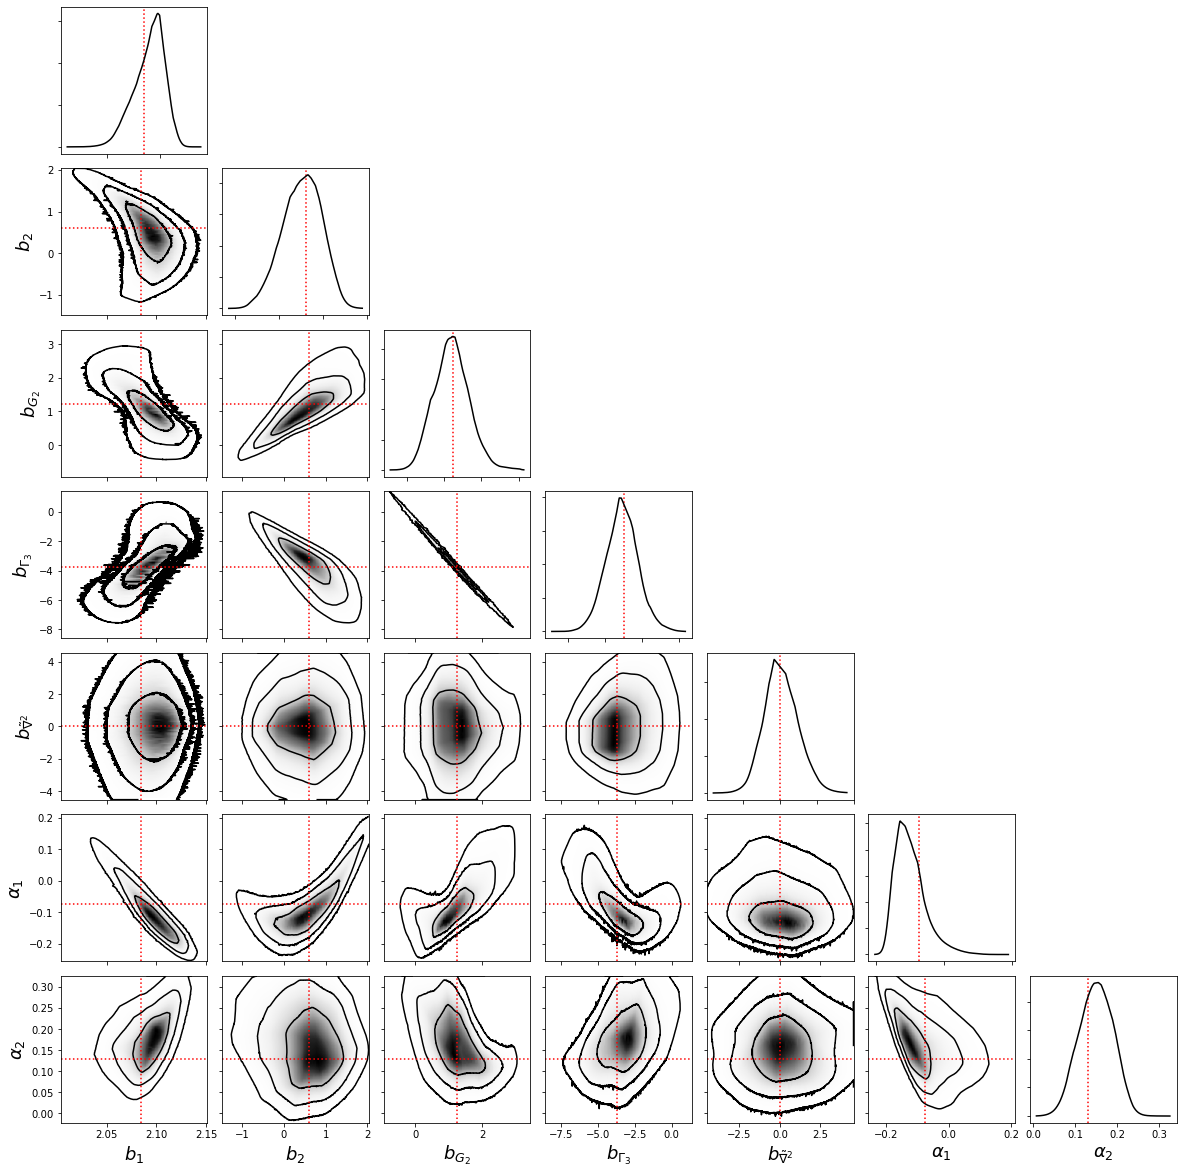

In [77]:
corner(re, re2, x0 = x0, cmap = 'Greys', dim = 20, max_n_points=20000, labels=labels,
      z0 = [2.08471636,0.60472895,1.23511048,-3.74206224,-7.8578e-06,-0.07530319,0.12946018])
plt.savefig('LSS-PSCorner.png')

In [19]:
def residual(params, ksim, powsim, sigmapow):
    b1 = params['b1']
    b2 = params['b2']
    bg2 = params['bg2']
    bg3 = params['bg3']
    cs = params['cs']
    alpha = params['alpha']
    ek2 = params['ek2']

    model = b1**2*(ptreeintev+p1loopintev)+ b1*b2*pid2intev+\
            2*b1*bg2*pig2intev+b1*(2*bg2+4/5*bg3)*pifg2intev+\
            1/4*b2**2*pid2d2intev+bg2**2*pig2g2intev+b2*bg2*pid2g2intev+\
            cs**2*pctrintev + (1+alpha)*shot[0,0,0] + ek2*shot[0,0,0]*ksim**2
                   

    return (model-powsim)/sigmapow


params = Parameters()
params.add('b1', value=1.0,min=-10.0,max=10.0)#,vary=False)
params.add('b2', value=1.0,min=-10.0,max=10.0)
params.add('bg2', value=1.0,min=-10.0,max=10.0)
params.add('bg3', value=0.0,min=-10.0,max=10.0)
params.add('cs',value=10.0,min=-100.0,max=100.0)#, vary=False)
params.add('alpha', value=0.0,min=-1.0,max=1.0)
params.add('ek2',value=1.0,min=-10.0,max=10.0)#, vary=False)

out = minimize(residual, params, args=(ksim, powsim, sigmapow))

#print(fit_report(out))

# calculate final result
final = powsim + out.residual*sigmapow

# write error report
print(fit_report(out))

# try to plot results
plt.xlabel('$k$ (h/Mpc)')
plt.ylabel('$fit$')
plt.errorbar(ksim,powsim, yerr=sigmapow, marker='o', ms=3, capsize=2, color=green1, label='sim' )
plt.plot(ksim,final, '-',label='fit',color=orange1)
plt.legend()
plt.title('fit nice')
plt.xscale('log')
plt.yscale('log')
#plt.savefig('plot.png')

plt.show()
plt.close()

NameError: name 'Parameters' is not defined